# Exercise Search Algorithms #


In the last session, we prepared different classes that are useful to solve search problems. You completed the Node class that we can use now for our first search strategy *breadth_first_graph_search*.

If you had problems implementing the node class, you can find the solution on ILIAS (search_solution.py).

First, you need to implement the breadth first search strategy:

Hints: 
- create the FIFO queue frontier using collections.py, that implements high performance data types. The collection.deque allows you to easily extend the queue with `frontier.append` and to remove items from the queue with `frontier.popleft()`
- remember that you can access the children of a node with the following code: `node.expand(problem)`
- return the goal node if you can find it


In [1]:
# %load -s Graph search_solution.py
class Graph:

    """A graph connects nodes (vertices) by edges (links).  Each edge can also
    have a length associated with it.  The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C.  You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added.  You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B.  'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)


In [2]:
# %load -s Node search_solution.py
class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state.  Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node.  Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1


    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action,
                    problem.path_cost(self.path_cost, self.state,
                                      action, next_state))
        return next_node
    
    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))


In [3]:
# %load -s UndirectedGraph search_solution.py
def UndirectedGraph(graph_dict=None):
    """Build a Graph where every edge (including future ones) goes both ways."""
    return Graph(graph_dict = graph_dict, directed=False)


In [4]:
# %load -s GraphProblem search_solution.py
class GraphProblem():

    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        self.initial = initial
        self.goal = goal
        self.graph = graph

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal
    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or infinity)


In [11]:
from collections import deque

def breadth_first_graph_search(problem):
    """ This implements the breadth first search strategy
        and returns the goal node """
    node = Node(problem.initial)
    frontier = deque([], len(problem.graph.graph_dict))
    frontier.appendleft(node) # appendleft makes the queue behave like a FIFO queue
    explored = []
    
    if problem.goal_test(node.state):
        return node
    
    while True:
        if len(frontier) == 0:
            return None
        node = frontier.pop()
        explored.append(node.state)
        for action in problem.actions(node.state):
            child_node = node.child_node(problem,action)
            if (child_node.state not in explored) and (child_node not in frontier):
                if problem.goal_test(child_node.state):
                    return child_node
            frontier.appendleft(child_node)

In [12]:
def depth_first_graph_search(problem):
    """ This implements the depth first search strategy
        and returns the goal node """
    node = Node(problem.initial)
    frontier = deque([], len(problem.graph.graph_dict))
    frontier.append(node) # append makes the queue behave like a LIFO queue
    explored = []
    
    if problem.goal_test(node.state):
        return node
    
    while True:
        if len(frontier) == 0:
            return None
        node = frontier.pop()
        explored.append(node.state)
        for action in problem.actions(node.state):
            child_node = node.child_node(problem,action)
            if (child_node.state not in explored) and (child_node not in frontier):
                if problem.goal_test(child_node.state):
                    return child_node
            frontier.append(child_node)

In [13]:
def depth_limited_graph_search(problem, limit):
    """ This implements the depth limited search strategy
        and returns the goal node """
    return recursive_dls(Node(problem.initial), problem, limit)
    
def recursive_dls(node, problem, limit):
    if problem.goal_test(node.state):
        return node
    elif limit == 0:
        return "cutoff"
    else:
        cutoff_occured = False
        for action in problem.actions(node.state):
            child = node.child_node(problem, action)
            result = recursive_dls(child, problem, limit-1)
            if result == "cutoff":
                cutoff_occured = True
            elif result != "failure":
                return result
        if cutoff_occured:
            return "cutoff"
        else:
            return "failure"      

In [14]:
def iterative_depth_first_graph_search(problem):
    """ This implements the depth limited search strategy
        and returns the goal node """
    depth = 0
    while True:
        result = recursive_dls(Node(problem.initial), problem, depth)
        if isinstance(result, Node):
            return result
        else:
            depth = depth + 1     
    
def recursive_dls(node, problem, limit):
    if problem.goal_test(node.state):
        return node
    elif limit == 0:
        return "cutoff"
    else:
        cutoff_occured = False
        for action in problem.actions(node.state):
            child = node.child_node(problem, action)
            result = recursive_dls(child, problem, limit-1)
            if result == "cutoff":
                cutoff_occured = True
            elif result != "failure":
                return result
        if cutoff_occured:
            return "cutoff"
        else:
            return "failure" 

Lets create a map from the text book example:

In [15]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))
romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

With this, we can test our search algorithm. We define our problem and let the breadth first search find a solution.

In [19]:
start = 'Sibiu'
goal = 'Bucharest'
problem = GraphProblem(start, goal, romania_map)
goal_node_bfs = breadth_first_graph_search(problem)
goal_node_dfs = depth_first_graph_search(problem)
goal_node_dls = depth_limited_graph_search(problem,1)
goal_node_idls = iterative_depth_first_graph_search(problem)

The following code will show you some information about the search:

In [20]:
def print_info_about_search(goal_node):
    if isinstance(goal_node, str):
        node = None
        reason = goal_node
    else:
        node = goal_node
        reason = None
    if node:
        print("The search algorithm reached " + node.state + " with a cost of " + str(node.path_cost) + ".")
        path = node.path()
        directions = ""
        for n in path:
            directions = directions + " > " + n.state
        print("The path is the following:" + directions)
    else: 
        if reason:
            print('no solution found, reason: ' + reason)
        else:
            print('no solution found')
            
def get_list_of_node_names(goal_node):
    node = goal_node
    if node:
        path = node.path()
        # we need a list of all states=hubs for the sbb example later
        node_names = []
        for n in path:
            node_names.append(n.state)
        return node_names

In [22]:
print_info_about_search(goal_node_bfs)
print_info_about_search(goal_node_dfs)
print_info_about_search(goal_node_dls)
print_info_about_search(goal_node_idls)

The search algorithm reached Bucharest with a cost of 310.
The path is the following: > Sibiu > Fagaras > Bucharest
The search algorithm reached Bucharest with a cost of 278.
The path is the following: > Sibiu > Rimnicu > Pitesti > Bucharest
no solution found, reason: cutoff
The search algorithm reached Bucharest with a cost of 310.
The path is the following: > Sibiu > Fagaras > Bucharest


Congratulations, you have implemented your first search algorithm!

## Swiss Railway System ##

The SBB OpenData platform (https://data.sbb.ch/) provides all train lines and hubs (Betriebsknotenpunkte) of their railway system. I briefly mentioned the data set in the beginning.

I've created a SBB class that can be used to import the data from the json file:



In [23]:
from sbb import SBB

sbb = SBB()
sbb.importData('linie-mit-betriebspunkten.json')

successfully imported 2787 hubs
successfully imported 401 train lines


The object `sbb` contains know all the hubs and trainlines. We can visualize the hubs with matplotlib:

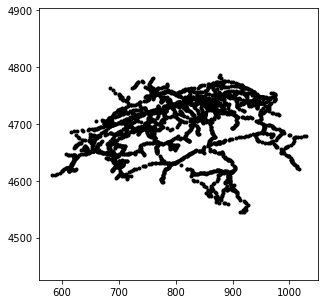

In [24]:
import matplotlib.pyplot as plt

def plot_hubs(hubs, labelNames = False):
    fig = plt.figure(figsize=(5,5))
    x =[]; y = []; names = [];
    for h in hubs:
        new_x = hubs[h].x
        new_y = hubs[h].y
        x.append(new_x)
        y.append(new_y)
        if labelNames:
            plt.text(new_x+0.01, new_y+0.01, h, fontsize=9)              
    plt.scatter(x,y, marker='.', color='black')  
    plt.axis('equal')
    
def plot_hubs_with_solution(hubs, solution_nodes, labelNames = False):
    fig = plt.figure(figsize=(12,12))
    x =[]; y = []; names = [];
    s_x = []; s_y=[]; s_names = [];
    
    start = solution_nodes[0]
    finish = solution_nodes[-1]
    for h in hubs:
        new_x = hubs[h].x
        new_y = hubs[h].y
        if h in solution_nodes:
            if h == start:
                plt.text(new_x+1.0, new_y+1.0, h, fontsize=20) #start
            elif h == finish:
                plt.text(new_x+1.0, new_y+1.0, h, fontsize=20) #stop
            else:
                s_x.append(new_x)
                s_y.append(new_y) 
        else:
            x.append(new_x)
            y.append(new_y)
    plt.scatter(x,y, marker='.', color='gray')  
    plt.scatter(s_x, s_y, marker='.', color='red')
    plt.axis('equal')
    
plot_hubs(sbb.hubs)

With a little imagination and geographic knowledge you can recognize the different regions of Switzerland.

We want to implement a search algorithm that finds the shortest way between 'Rotkreuz' and 'Thalwil'. In this exercise, we are not restricted to the official train lines. We can use the railway system with our own search agent and decide at each hub in which direction we want to go. If you have successfully implemented the classes above, the following code should execute and provide the directions between Rotkreuz and Thalwil.

In [25]:
start = 'Rotkreuz'
goal = 'Thalwil'
sbb_map = UndirectedGraph(sbb.createMap())
problem = GraphProblem(start, goal, sbb_map)
node = breadth_first_graph_search(problem)
print_info_about_search(node)

The search algorithm reached Thalwil with a cost of 40.672000000000004.
The path is the following: > Rotkreuz > Hunenberg_Chamleten > Hunenberg_Zythus > Cham > Cham_Alpenblick > Zug_Chollermuli > Zug_Schutzengel > Zug > Zug_Nord_Abzw > Baar_Lindenpark > Baar_Neufeld > Baar > Litti_Baar > Nidelbad_Sud_Abzw > Nidelbad_Ost_Abzw > Nidelbad_Abzw > Nidelbad_Ost_Abzw > Thalwil_Nord_Abzw > Thalwil


In [26]:
sbb_map = UndirectedGraph(sbb.createMap())
problem = GraphProblem(start, goal, sbb_map)
#node = depth_first_graph_search(problem)
#print_info_about_search(node)

In [27]:
sbb_map = UndirectedGraph(sbb.createMap())
problem = GraphProblem(start, goal, sbb_map)
node = depth_limited_graph_search(problem, 15)
print_info_about_search(node)

no solution found, reason: cutoff


In [28]:
sbb_map = UndirectedGraph(sbb.createMap())
problem = GraphProblem(start, goal, sbb_map)
node = iterative_depth_first_graph_search(problem)
print_info_about_search(node)

The search algorithm reached Thalwil with a cost of 36.906.
The path is the following: > Rotkreuz > Hunenberg_Chamleten > Hunenberg_Zythus > Cham > Cham_Alpenblick > Zug_Chollermuli > Zug_Schutzengel > Zug > Zug_Nord_Abzw > Baar_Lindenpark > Baar_Neufeld > Baar > Litti_Baar > Sihlbrugg > Horgen_Oberdorf > Oberrieden_Dorf > Thalwil


##  More Uninformed Search Algorithms ##

As you know, the breadth-search algorithm is just one of many search strategies. Implement the following search algorithms and evaluate their performance. You might have to adapt (or create a subclass) of certain classes we used before, to determine the depth of the search tree for example.

1. Depth-First Search (DFS)
1. Depth-Limited Search (DLS)
1. Iterative Deepening Search (IDS)


Try to visualize which nodes (hubs) have been visited by the search algorithm. Create for each search strategy an image that shows the start, the goal, the solution path and all the visited nodes.

Answer the following questions for each algorithm:

1. How does your algorithm deal with loops? 
1. Can you make an estimate about the time and memory requirements? 
1. Is your algorithm complete and optimal?

Fill the following table:

| Algorithm | start   | goal | cost | number of nodes visited | maximal stored nodes | found solution ? | optimal solution? |
|------|------|-----|-----|-----|-----|-----|-----|
| BFS|Rotkreuz|Thalwil|40.67|?|?|y|n
| DFS|Rotkreuz|Thalwil|NONE|?|?|n|n
| DLS|Rotkreuz|Thalwil|36.9|?|?|y|n
| IDS|Rotkreuz|Thalwil|36.9|?|?|y|n




What is special about the sbb railway map in terms of complexity (branching factor, depth)? How could you preprocess the data set in order to reduce the search space?


## Breadth Search

The search algorithm reached Thalwil with a cost of 40.672000000000004.
The path is the following: > Rotkreuz > Hunenberg_Chamleten > Hunenberg_Zythus > Cham > Cham_Alpenblick > Zug_Chollermuli > Zug_Schutzengel > Zug > Zug_Nord_Abzw > Baar_Lindenpark > Baar_Neufeld > Baar > Litti_Baar > Nidelbad_Sud_Abzw > Nidelbad_Ost_Abzw > Nidelbad_Abzw > Nidelbad_Ost_Abzw > Thalwil_Nord_Abzw > Thalwil


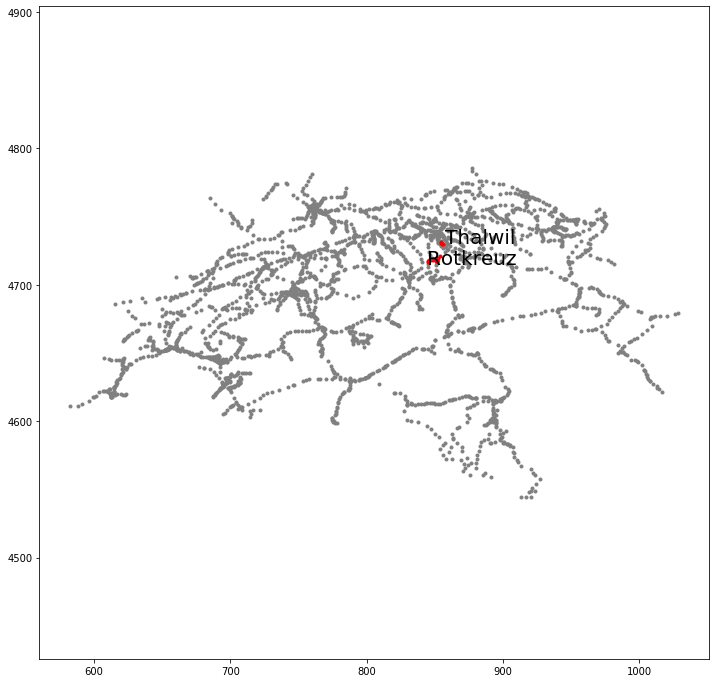

In [33]:
start = 'Rotkreuz'
goal = 'Thalwil'
sbb_map = UndirectedGraph(sbb.createMap())
problem = GraphProblem(start, goal, sbb_map)
node= breadth_first_graph_search(problem)
node_names = get_list_of_node_names(node)
plot_hubs_with_solution(sbb.hubs, node_names, True)
print_info_about_search(node)

### Questions:

##### 1. How does your algorithm deal with loops? 

Can handle it
##### 2. Can you make an estimate about the time and memory requirements? 

Slides
##### 3. Is your algorithm complete and optimal?

Not optimal (different costs), but complete

## Depth-First Search

In [34]:
start = 'Rotkreuz'
goal = 'Thalwil'
sbb_map = UndirectedGraph(sbb.createMap())
problem = GraphProblem(start, goal, sbb_map)
#node = depth_first_graph_search(problem)
#node_names = get_list_of_node_names(node)
#plot_hubs_with_solution(sbb.hubs, node_names, True)
#print_info_about_search(node)

### Questions:

##### 1. How does your algorithm deal with loops? 

Can't handle it (that's why it doesn't find a solution)
##### 2. Can you make an estimate about the time and memory requirements? 

Slides
##### 3. Is your algorithm complete and optimal?

Not optimal (different costs), but complete

## Depth-Limited Search

The search algorithm reached Thalwil with a cost of 36.906.
The path is the following: > Rotkreuz > Hunenberg_Chamleten > Hunenberg_Zythus > Cham > Cham_Alpenblick > Zug_Chollermuli > Zug_Schutzengel > Zug > Zug_Nord_Abzw > Baar_Lindenpark > Baar_Neufeld > Baar > Litti_Baar > Sihlbrugg > Horgen_Oberdorf > Oberrieden_Dorf > Thalwil


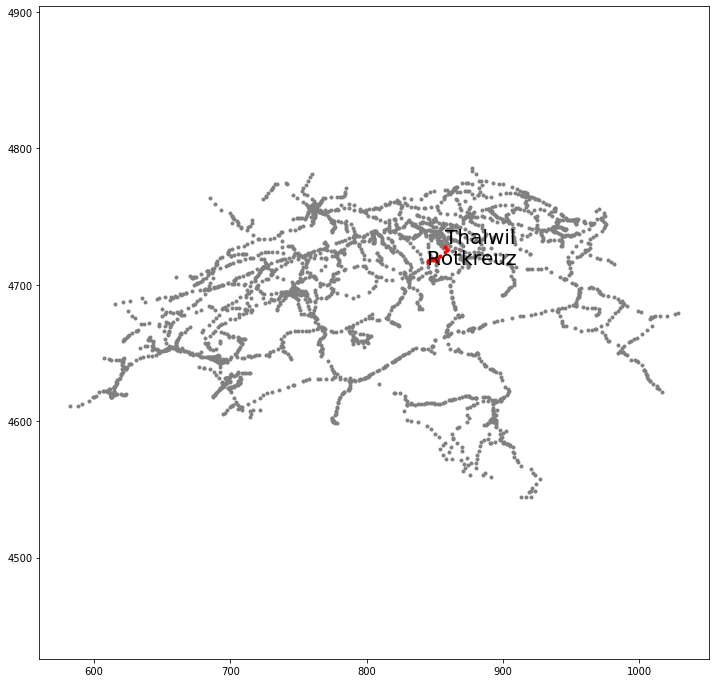

In [35]:
start = 'Rotkreuz'
goal = 'Thalwil'
sbb_map = UndirectedGraph(sbb.createMap())
problem = GraphProblem(start, goal, sbb_map)
node = depth_limited_graph_search(problem, 20)
node_names = get_list_of_node_names(node)
plot_hubs_with_solution(sbb.hubs, node_names, True)
print_info_about_search(node)

### Questions:

##### 1. How does your algorithm deal with loops? 

Can handle it (because of depth limit)
##### 2. Can you make an estimate about the time and memory requirements? 

Slides
##### 3. Is your algorithm complete and optimal?

Not optimal, but complete if l = deepest node

## Iterative-Deepening Search

The search algorithm reached Thalwil with a cost of 36.906.
The path is the following: > Rotkreuz > Hunenberg_Chamleten > Hunenberg_Zythus > Cham > Cham_Alpenblick > Zug_Chollermuli > Zug_Schutzengel > Zug > Zug_Nord_Abzw > Baar_Lindenpark > Baar_Neufeld > Baar > Litti_Baar > Sihlbrugg > Horgen_Oberdorf > Oberrieden_Dorf > Thalwil


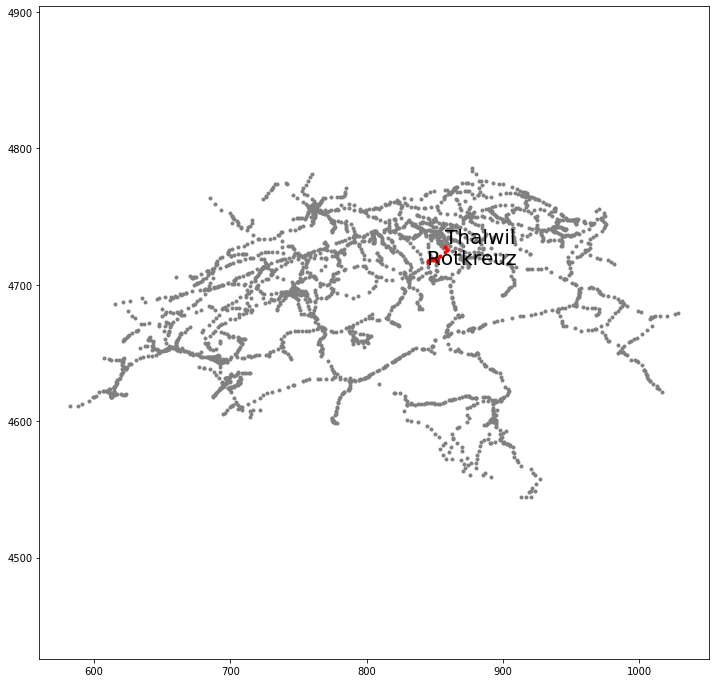

In [36]:
start = 'Rotkreuz'
goal = 'Thalwil'
sbb_map = UndirectedGraph(sbb.createMap())
problem = GraphProblem(start, goal, sbb_map)
node = iterative_depth_first_graph_search(problem)
node_names = get_list_of_node_names(node)
plot_hubs_with_solution(sbb.hubs, node_names, True)
print_info_about_search(node)

### Questions:

##### 1. How does your algorithm deal with loops? 

Can handle it (because of depth limit)
##### 2. Can you make an estimate about the time and memory requirements? 

Slides
##### 3. Is your algorithm complete and optimal?

Not optimal (different costs), but complete